Inizializzation.

This Cell download and intstall ROOT in python 2 environment. 

Runs this part of the script only when you have to init a new machine e and working space

In [2]:
# installazione di ROOT dal CERN
!mkdir -p APPS
!pwd
!cd APPS && wget https://root.cern.ch/download/root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz 
!cd APPS && tar -xf root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz

# main paths for ROOT  
import sys
sys.path.append("/content/APPS/root/lib")
import ctypes
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libCore.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libThread.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libImt.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libRIO.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libNet.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libTree.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libMathCore.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libMatrix.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libHist.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libGraf.so')
# installation and root-numpy main PATH
!pip install root-numpy
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libMultiProc.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libGpad.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libGraf3d.so')
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libTreePlayer.so')
# patch to open online FILE
! sudo apt-get install libdavix0v5
ctypes.cdll.LoadLibrary('/content/APPS/root/lib/libRDAVIX.so')
! echo "Davix.GSI.CACheck: n" >> $ROOTSYS/etc/system.rootrc
! cp $ROOTSYS/etc/system.rootrc $HOME/.rootrc
! tail -1 $HOME/.rootrc

/content
--2020-05-04 16:54:30--  https://root.cern.ch/download/root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz
Resolving root.cern.ch (root.cern.ch)... 137.138.13.143, 2001:1458:201:45::100:b
Connecting to root.cern.ch (root.cern.ch)|137.138.13.143|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137415272 (131M) [application/x-gzip]
Saving to: ‘root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz’

root_v6.13.08.Linux 100%[===================>] 131.05M  26.6MB/s    in 5.7s    

2020-05-04 16:54:36 (23.0 MB/s) - ‘root_v6.13.08.Linux-ubuntu18-x86_64-gcc7.3.tar.gz’ saved [137415272/137415272]

     |████████████████████████████████| 522kB 2.7MB/s 
  Created wheel for root-numpy: filename=root_numpy-4.8.0-cp27-cp27mu-linux_x86_64.whl size=1075529 sha256=c09aedeef828ba089a01d1b8e5d418e4b8ac973c763f7ae4dc46125fad83664b
  Stored in directory: /root/.cache/pip/wheels/f0/3c/18/62ccf3aec0284175916617d699f179d7cdbe4de0c7070be2a5
Successfully built root-numpy
Reading pack

This Cell Load funcions (libraries) to retrive data from swift CYGNO server

Runs this part of the script only when you have to init a new machine e and working space

In [1]:
#!pip install -q  python-swiftclient
#!pip install -q  keystoneauth1
#!pip install -q  h5py
import sys
import ctypes
import matplotlib.pyplot as plt
import numpy as np    
import ROOT
import root_numpy as rtnp
! rm cygnus_lib.*; rm mylib.*
! wget https://raw.githubusercontent.com/gmazzitelli/cygno/master/cygnus_lib.py
! wget https://raw.githubusercontent.com/gmazzitelli/cygno/master/mylib.py
sys.path.append('.')
import cygnus_lib as cy
import mylib as my
%matplotlib inline
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import chisquare
import scipy.stats as stats
from itertools import combinations
import math
import os
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

x_resolution = y_resolution = 2048
cy.set_atlas_style('square')
!mkdir -p data

Welcome to JupyROOT 6.20/00
--2020-05-20 19:20:34--  https://raw.githubusercontent.com/gmazzitelli/cygno/master/cygnus_lib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.240.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.240.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24130 (24K) [text/plain]
Saving to: ‘cygnus_lib.py’

cygnus_lib.py       100%[===================>]  23.56K  --.-KB/s    in 0.02s   

2020-05-20 19:20:34 (1.31 MB/s) - ‘cygnus_lib.py’ saved [24130/24130]

--2020-05-20 19:20:34--  https://raw.githubusercontent.com/gmazzitelli/cygno/master/mylib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.240.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.240.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17634 (17K) [text/plain]
Saving to: ‘mylib.py’

mylib.py            100%[===================>]

Generate data stream file looking for close clusters in any images: 

1.   download pedestal file [run_ped]
2.   download dafa file/s [runI] from specifc location [dataSelection]
3.   Serch for cluster with DBSCAN
4.   save output in txt file


In [28]:
import time
t = time.clock()
runI          = [2277] 
run_ped       = 2154 
cimax         = 300
cimin         = 0 
dataSelection = 'LAB'
rescale       = 512
nsigma        = 1.5

def rebinning(signal,rebin):
  if 2048%rebin == 0:
    rebin_signal = np.zeros((rebin,rebin))
    ratio = int(2048/rebin)
    h = 0

    for i in np.arange(0,2048,1):

      k = 0

      for j in np.arange(0,2048,1):

        rebin_signal[h,k] += signal[i,j]

        if (j+1)%ratio == 0:

          k += 1

      if (i+1)%ratio == 0:

        h += 1

    return rebin_signal

  else:
    print('Error: Rebinning lenght must be a factor of 2048')
    return 

try:
  fh5 = ("run%d_mean.h5" % (run_ped))
  cmd = 'wget -nv https://raw.githubusercontent.com/gmazzitelli/cygno/master/data/'+fh5+' -O ./data/'+fh5
  os.system(cmd)
  fh5 = ("run%d_sigma.h5" % (run_ped))
  cmd = 'wget -nv https://raw.githubusercontent.com/gmazzitelli/cygno/master/data/'+fh5+' -O ./data/'+fh5
  os.system(cmd)
except:
  print ("No Pedestal file for run %s on remote repo" % run_ped)

#########################

try:
    fileoutm = ("./data/run%d_mean.h5" % (run_ped))
    m_image = cy.read_image_h5(fileoutm)
    PedOverMax = m_image[m_image > cimax].size
    print ("Pedestal mean: %.2f, sigma: %.2f, over th. (%d) %d" % 
       (m_image[m_image<cimax].mean(), 
        np.sqrt(m_image[m_image<cimax].var()), cimax,
        (m_image>cimax).sum()))
except:
    print ("No Pedestal file for run %s, run script runs-pedestals.ipynb" % run_ped)
    print ("STOP")

    
try: 
    fileouts = ("./data/run%d_sigma.h5" % (run_ped))
    s_image = cy.read_image_h5(fileouts)
    print ("Sigma mean: %.2f, sigma: %.2f, over th. (50) %d" % 
   (s_image[s_image<50].mean(), 
    np.sqrt(s_image[s_image<50].var()), 
    (s_image>50).sum()))
except:
    print ("No Sigma file for run %s, run script runs-pedestals.ipynb" % run_ped)
    print ("STOP")

#########################

th_image   = np.round(m_image + nsigma*s_image)                                     # Threshold given pedestal
print ("light over Th: %.2f " % (th_image.sum()-m_image.sum()))
    
for nRi in range(0,len(runI)):                                                      # Ciclo run
    try:
        print ('Open file: '+cy.swift_root_file(dataSelection, runI[nRi]))
        f = ROOT.TFile.Open(cy.swift_root_file(dataSelection, runI[nRi]))           # Scarica il file della run nell'array runI

        print ('Find Keys: '+str(len(f.GetListOfKeys())))
        pic, wfm = cy.root_TH2_name(f)                                              # Prende il nome di ogni immagine nella run
        max_image = len(pic)                                                        # Conta il numero di immagini presenti
        max_wfm = len(wfm)
        print ("# of Images (TH2) Files: %d " % (max_image))
        print ("# of Waveform (TH2) Files: %d " % (max_wfm))
        nImag=max_image
    except:
        print ("ERROR: No file %d" % (runI[nRi]))
        break
        
    for eps in np.arange(6.5,13,1):
        
        for min_samples in np.arange(2*eps,11*eps,eps):
            
            t0= time.clock()
            print('EPS %.1f MIN_SAMPLES %d' %(eps,min_samples))

            data_to_save = []
            files = ("./data/dbscan_run%d_ped_%d_eps%.1f_mins%d.txt" %                     # Prepara il file da salvare
                             (runI[nRi],run_ped,eps,min_samples))
            for iTr in range(0, 200):                                                      # Ciclo immagini
                points_list = []
                if iTr % 10 == 0:                                                          # Patch in order overcome the problem of ROOT memory garbage
                     print ('Processing RUN: ', runI[nRi], 'Event: ', iTr)
        
                image = rtnp.hist2array(f.Get(pic[iTr])).T                                 # Root hist to numpy array
        
                real_image = image - m_image
                real_th    = th_image - m_image
        
                for i in np.arange(900,1300,1):                                            # Crea la lista dei punti sopra soglia 
                  for j in  np.arange(750,1250,1):
                    if real_image[i,j] > real_th[i,j] and real_image[i,j] < cimax:
                      points_list.append([i,j,real_image[i][j]])
        
                points = np.array(points_list)
                print(len(points))                                  
        
                dbscan = DBSCAN(eps,min_samples).fit(points)                               # DBSCAN 
        
                unique_labels = set(dbscan.labels_)
                colors = [plt.cm.Spectral(each)
                for each in np.linspace(0, 1, len(unique_labels))]
        
                for ic,col in zip(unique_labels,colors):                                   # Ciclo cluster
                    ph = 0.
                    yc = points[:,1][dbscan.labels_==ic]      
                    xc = points[:,0][dbscan.labels_==ic]
                    ph, dim = cy.cluster_par(yc, xc, real_image)                           # Ritorna n_fotoni e n_pixel del cluster ic 
                    width, height, pearson = cy.confidence_ellipse_par(yc,xc)            
        
                    if ic != -1:

                      #plt.plot(xc[:], yc[:], '.',markerfacecolor=tuple(col),
                      #        markeredgecolor=tuple(col), markersize=1)
        
                      x0start = xc[0]
                      y0start = yc[0]
                      x0end = xc[-1]
                      y0end = yc[-1]
                      data_to_save.append([iTr, ic, dim, ph, ph/dim, 
                                         x0start, y0start, x0end, y0end, width, height, pearson])
        
                #fig = plt.gcf()
                #fig.set_size_inches(10, 10)
                #plt.show()
                #print(iTr)
        
            np.savetxt(files, data_to_save, fmt='%.10e', delimiter=" ")
            print ("out file", files)
            t1 = time.clock() - t0
            print('Time elapsed %lf \n\n' %t1)
            
t2 = time.clock() - t
print('Total running time %lf' %t2)

Pedestal mean: 99.57, sigma: 0.96, over th. (300) 10
Sigma mean: 2.51, sigma: 2.15, over th. (50) 10
light over Th: 15750215.16 
Open file: https://swift.cloud.infn.it:8080/v1/AUTH_1e60fe39fba04701aa5ffc0b97871ed8/Cygnus/Data/LAB/histograms_Run02277.root
Find Keys: 1896
# of Images (TH2) Files: 948 
# of Waveform (TH2) Files: 948 
EPS 6 MIN_SAMPLES 13
('Processing RUN: ', 2277, 'Event: ', 0)
27869
9332
9372
11091
9450
8920
9734
10045
9660
9297
('Processing RUN: ', 2277, 'Event: ', 10)
9237
9417
9238
9954
9806
9976
9290
9886
9255
9349
('Processing RUN: ', 2277, 'Event: ', 20)
10450
9087
8956
9916
9265
8886
9809
9294
11380
9732
('Processing RUN: ', 2277, 'Event: ', 30)
9191
8889
9705
9571
8725
8963
9067
9313
9111
9345
('Processing RUN: ', 2277, 'Event: ', 40)
9449
9862
11152
9482
9203
9036
9547
8969
9230
9949
('Processing RUN: ', 2277, 'Event: ', 50)
9975
9007
9157
9351
9695
10206
9533
9386
10370
10172
('Processing RUN: ', 2277, 'Event: ', 60)
9008
9084
8858
9329
9753
9350
10387
10910
97

2020-05-15 18:27:23 URL:https://raw.githubusercontent.com/gmazzitelli/cygno/master/data/run2154_mean.h5 [33556480/33556480] -> "./data/run2154_mean.h5" [1]
2020-05-15 18:27:25 URL:https://raw.githubusercontent.com/gmazzitelli/cygno/master/data/run2154_sigma.h5 [33556480/33556480] -> "./data/run2154_sigma.h5" [1]


In [3]:
# outputs (.h5 are the pedestal files)
!ls data

dbscan_run2277_ped_2154_eps10.0_mins100.txt
dbscan_run2277_ped_2154_eps10.0_mins20.txt
dbscan_run2277_ped_2154_eps10.0_mins30.txt
dbscan_run2277_ped_2154_eps10.0_mins40.txt
dbscan_run2277_ped_2154_eps10.0_mins50.txt
dbscan_run2277_ped_2154_eps10.0_mins60.txt
dbscan_run2277_ped_2154_eps10.0_mins70.txt
dbscan_run2277_ped_2154_eps10.0_mins80.txt
dbscan_run2277_ped_2154_eps10.0_mins90.txt
dbscan_run2277_ped_2154_eps10.5_mins105.txt
dbscan_run2277_ped_2154_eps10.5_mins21.txt
dbscan_run2277_ped_2154_eps10.5_mins31.txt
dbscan_run2277_ped_2154_eps10.5_mins42.txt
dbscan_run2277_ped_2154_eps10.5_mins52.txt
dbscan_run2277_ped_2154_eps10.5_mins63.txt
dbscan_run2277_ped_2154_eps10.5_mins73.txt
dbscan_run2277_ped_2154_eps10.5_mins84.txt
dbscan_run2277_ped_2154_eps10.5_mins94.txt
dbscan_run2277_ped_2154_eps11.0_mins110.txt
dbscan_run2277_ped_2154_eps11.0_mins22.txt
dbscan_run2277_ped_2154_eps11.0_mins33.txt
dbscan_run2277_ped_2154_eps11.0_mins44.txt
dbscan_run2277_ped_2154_eps11.0_mins55.txt
dbscan_r

da fare:
1.   studiarsi DBSCAN e come vengono selzionati i dati
2.   mostrare il risultato di cluserizzazione di DBSCAN su ogni imagine (fare un debug delo script mostrando le immagini)
2.   con panda caricare i file di output
2.   guardarsi le varie variabili, visualizzarli, capire che significano
3.   fare la distribuzione del numero di fotoni
4.   fittarla con un esponenziale (coda del fondo) piu' gaussina (picco dei fotoni)
5.   studiare l'andamento del picco del ferro nel tempo per i run pari tra 1856 e 2031





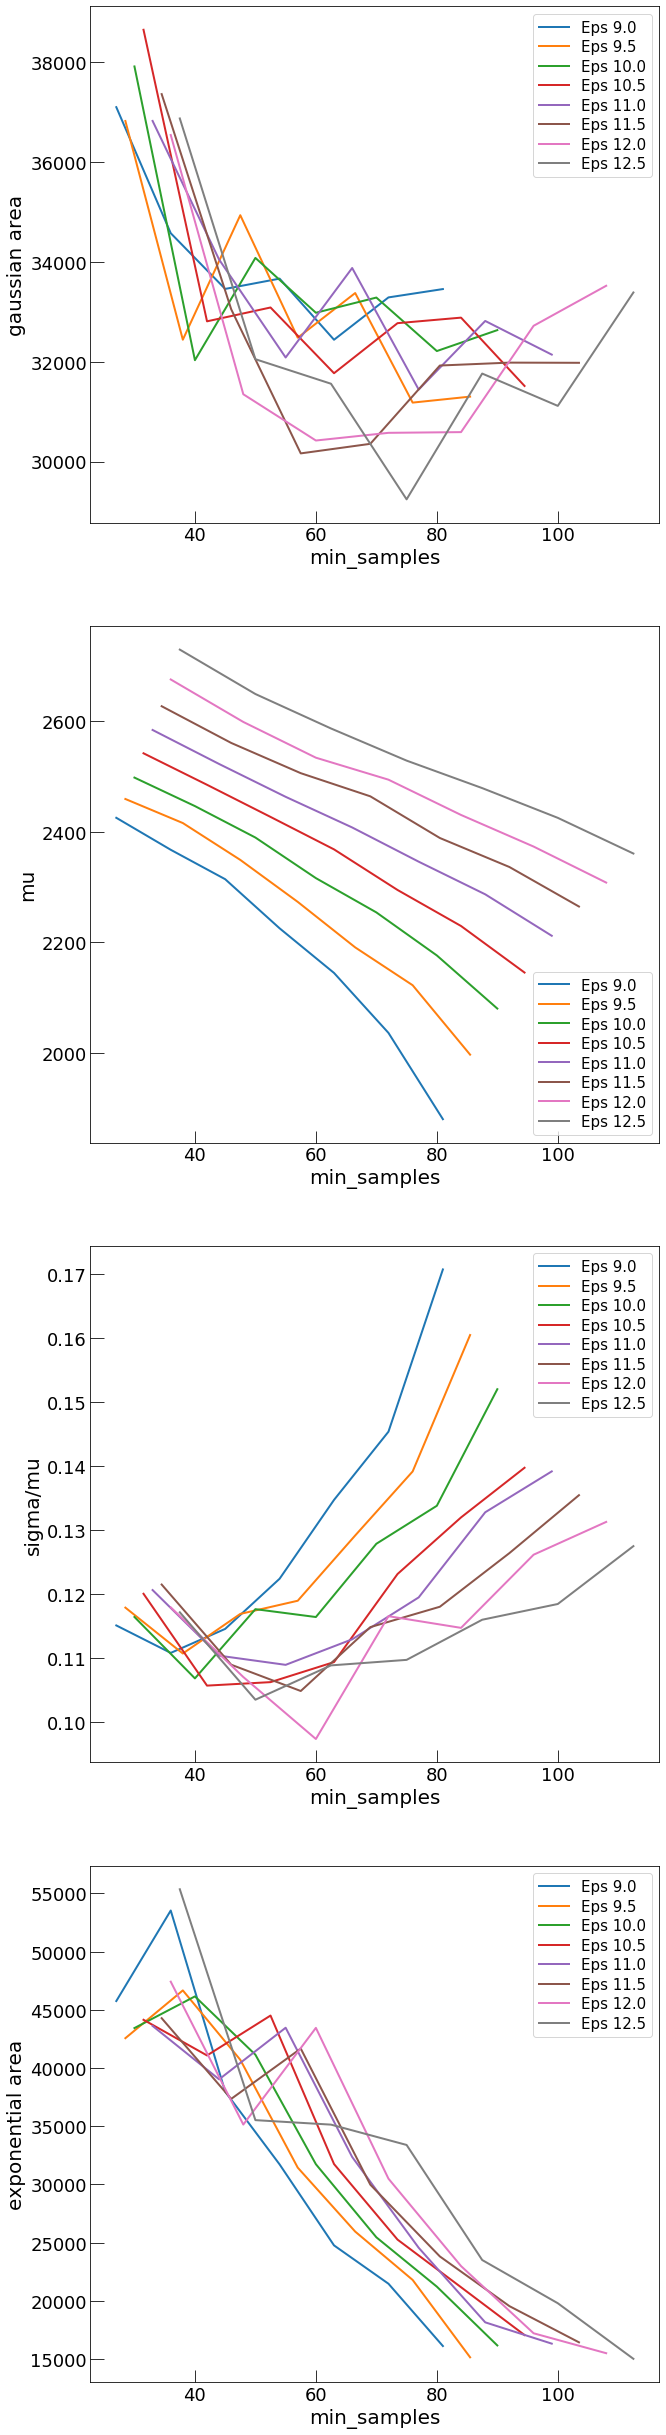

In [27]:
from scipy.optimize import curve_fit

def phot(x,a,b,c,d,e):
            
            return a*np.exp(-b*x) + e*np.exp(-0.5*((x-c)/d)**2) 

hist_mu = []

for eps in np.arange(9,13,0.5):
    area_gaus = []
    area_exp = []
    fit_mu = []
    fit_sigma = []
    min_samples_range = []
    
    for min_samples in np.arange(3*eps,10*eps,eps):
        
        data = pd.read_csv('./data/dbscan_run2277_ped_2154_eps%.1f_mins%d.txt' %(eps,min_samples),sep=" ",names=[0,1,2,3,4,5,6,7,8,9,10,11])
            
        histogram_phot = data[[0,3]].to_numpy()
            
        histogram_phot = histogram_phot[histogram_phot[:,1]<5000]
        
        yphot,xphot = np.histogram(histogram_phot[:,1],bins=50)
        xphot = np.delete(xphot,-1)
                
        par, cov = curve_fit(phot,xphot,yphot,p0=[1,0.01,2000,300,1],bounds=(0,np.inf))
            
        hist_mu.append(par[2])
        fit_mu.append(par[2])
        fit_sigma.append(par[3]/par[2])
            

        area_gaus.append(par[4]*par[3]*np.sqrt(2*np.pi))
        area_exp.append(par[0]/par[1])
        min_samples_range.append(min_samples)
        
            
        #plt.hist(histogram_phot[:,1],range=[0,max(histogram_phot[:,1])],bins=50,histtype='step',linewidth=2)
        #plt.plot(xphot,par[0]*np.exp(-xphot*par[1])+ par[4]*np.exp(-0.5*((xphot-par[2])/par[3])**2),linewidth=2)
        #plt.plot(xphot,par[0]*np.exp(-xphot*par[1]),linewidth=2)
        #plt.plot(xphot,par[4]*np.exp(-0.5*((xphot-par[2])/par[3])**2),linewidth=2)
        #plt.title('$N_{photons}$ histogram run 2277 eps %d min_samples %d' %(eps,min_samples))
        #plt.xlabel('$N_{photons}$')
        #fig = plt.gcf()
        #fig.set_size_inches(10, 10)
        #plt.grid()
        #plt.show()
            
    
    
    plt.subplot(4,1,1)
    plt.plot(min_samples_range[:],area_gaus[:],label='Eps %.1f'%eps,linewidth=2)
    plt.xlabel('min_samples')
    plt.ylabel('gaussian area')
    plt.legend(loc='upper right',fontsize=15)
    plt.subplot(4,1,4)
    plt.plot(min_samples_range[:],area_exp[:],label='Eps %.1f'%eps,linewidth=2)
    plt.xlabel('min_samples')
    plt.ylabel('exponential area')
    plt.legend(loc='upper right',fontsize=15)
    plt.subplot(4,1,2)
    plt.plot(min_samples_range[:],fit_mu[:],label='Eps %.1f'%eps,linewidth=2)
    plt.xlabel('min_samples')
    plt.ylabel('mu')
    plt.legend(loc='lower right',fontsize=15)
    plt.subplot(4,1,3)
    plt.plot(min_samples_range[:],fit_sigma[:],label='Eps %.1f'%eps,linewidth=2)
    plt.xlabel('min_samples')
    plt.ylabel('sigma/mu')
    plt.legend(loc='upper right',fontsize=15)
    
fig = plt.gcf()
fig.set_size_inches(10, 40)
plt.show()


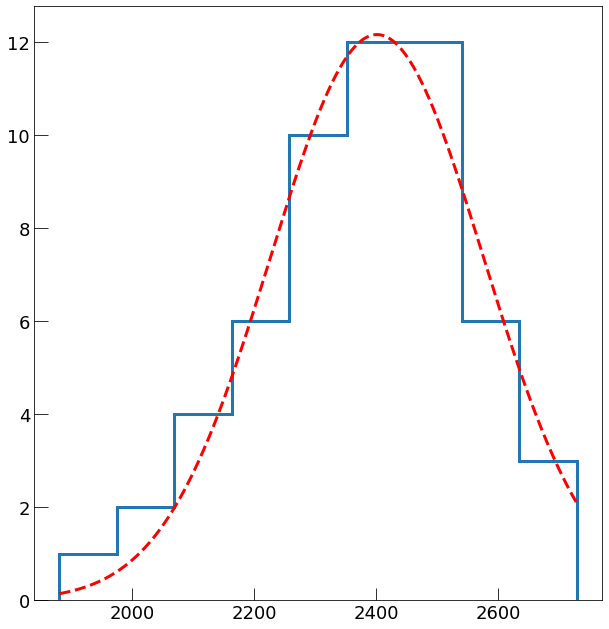

(2401.643399701724, 174.66568403308895)


In [45]:
def mu(x,a,b,c):
            
    return a*np.exp(-0.5*((x-b)/c)**2)

hist_y, hist_x = np.histogram(hist_mu,bins=9)

hist_x = (hist_x[1:]+hist_x[:-1])/2

par1, cov1 = curve_fit(mu,hist_x,hist_y,bounds=(0,np.inf),p0=[10,2000,100]) 

hist_x = np.linspace(min(hist_mu),max(hist_mu),1000)

fig = plt.gcf()
fig.set_size_inches(10, 10)
plt.hist(hist_mu,bins=9,histtype='step',linewidth=3)
plt.plot(hist_x,mu(hist_x,par1[0],par1[1],par1[2]),'r--',linewidth=3)
plt.show()

print(par1[1],par1[2])